In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [177]:
df = pd.read_csv('covid_usa.csv', index_col=[0], parse_dates=[0])
df=df.dropna()
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 674 entries, 2020-05-01 to 2022-03-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cases   674 non-null    int64
dtypes: int64(1)
memory usage: 10.5 KB
None


,cases
date,
2020-05-01,33970
2020-05-02,29474
2020-05-03,26140
2020-05-04,21962
2020-05-05,23709
2020-05-06,24506
2020-05-07,28478
2020-05-08,27648
2020-05-09,24868


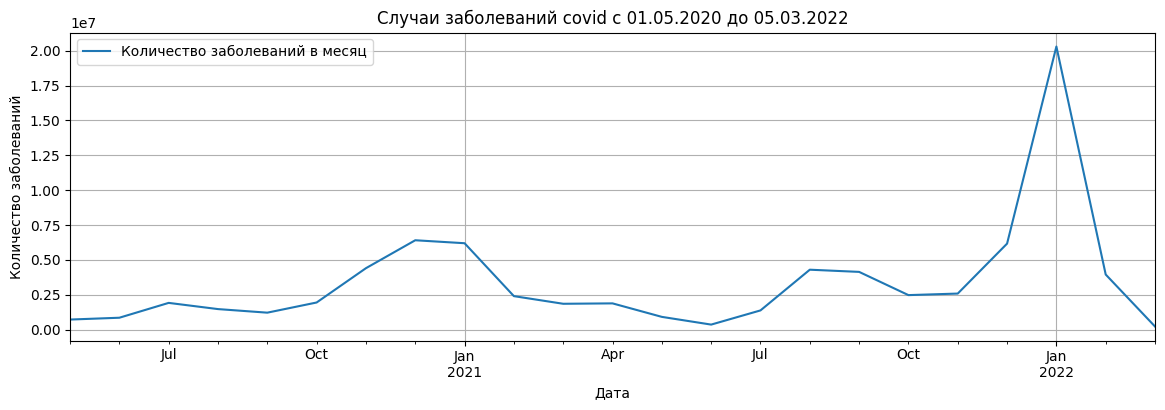

In [178]:
df.resample('1M').sum().plot(figsize=(14,4), 
                               grid=True, 
                               xlabel='Дата',
                               ylabel='Количество заболеваний',
                               title='Случаи заболеваний covid с 01.05.2020 до 05.03.2022')
plt.legend(['Количество заболеваний в месяц'])
plt.show()

как видно по графику, первый большой всплеск произошел осенью и зимой 2020-2021, основной всплеск произошел примерно в тоже время через год.
Посмотрим срезы (дневной, недельный)

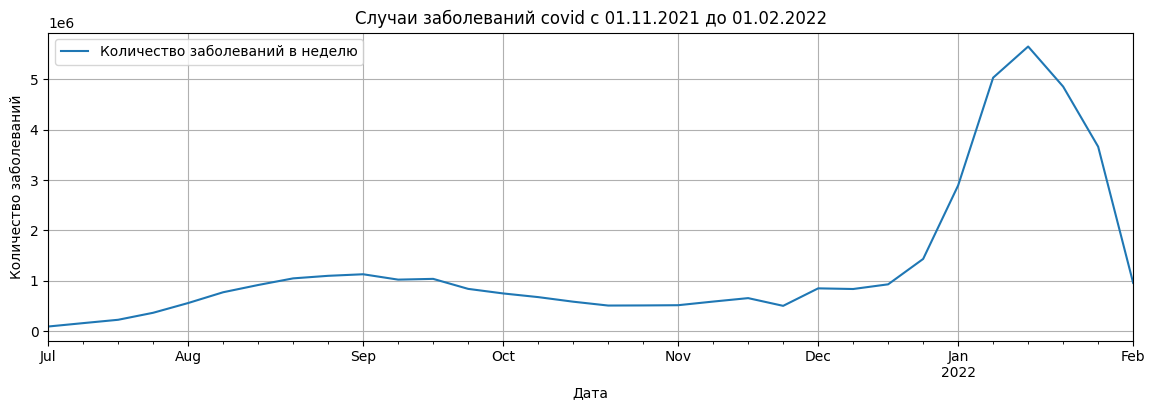

In [179]:
df['2021-07-01':'2022-02-01'].resample('1W').sum().plot(figsize=(14,4), 
                               grid=True, 
                               xlabel='Дата',
                               ylabel='Количество заболеваний',
                               title='Случаи заболеваний covid с 01.11.2021 до 01.02.2022')
plt.legend(['Количество заболеваний в неделю'])
plt.show()

мы видим,что в срезе по неделям все еще видно ту же закономерность,сделаем срез на самых больших неделях

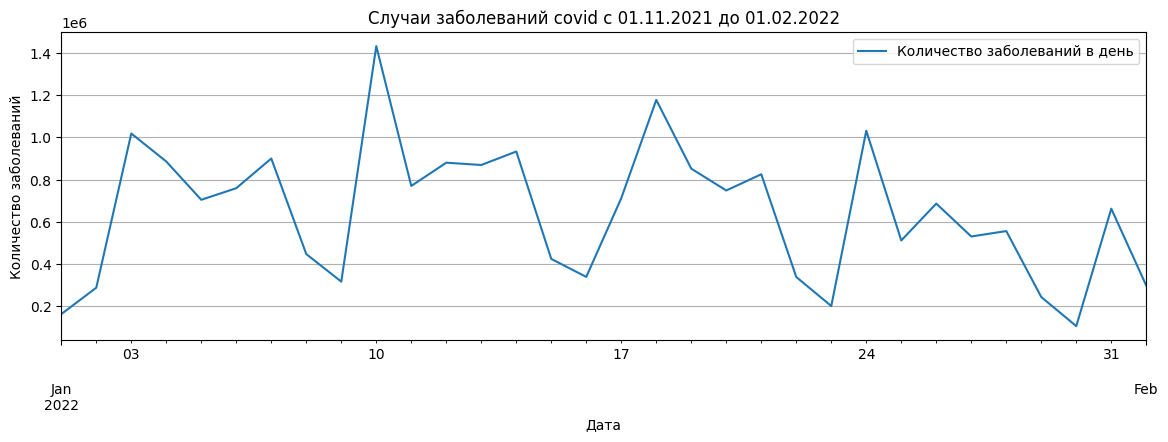

In [180]:
df['2022-01-01':'2022-02-01'].resample('1D').sum().plot(figsize=(14,4), 
                                grid=True, 
                               xlabel='Дата',
                               ylabel='Количество заболеваний',
                               title='Случаи заболеваний covid с 01.11.2021 до 01.02.2022')
plt.legend(['Количество заболеваний в день'])
plt.show()

мы видим закономерность, которая прослеживается на срезе по дням в самый разгар заболеваний, это рабочие дни (10-понедельник), мы понимаем, что на выходных заболеваний меньше, в понедельник больше всего.
Думаю, что можно начинать подготовку и обучение

In [181]:
# создадим новые призанки
df_copy = df.copy()

df_copy['month'] = df_copy.index.month
df_copy['day'] = df_copy.index.day
df_copy['dayofweek'] = df_copy.index.dayofweek
df_copy['rolling_mean'] = df_copy['cases'].shift().rolling(5).mean()
df_copy['std']=df_copy['cases'].shift().rolling(5).std()
    
for lag in range(1, 5):
    df_copy[f'lag_{lag}'] = df_copy['cases'].shift(lag)

df_copy = df_copy.dropna()
df_copy.head(10)

,cases,month,day,dayofweek,rolling_mean,std,lag_1,lag_2,lag_3,lag_4
date,,,,,,,,,,
2020-05-06,24506,5,6,2,27051.0,4786.446908,23709.0,21962.0,26140.0,29474.0
2020-05-07,28478,5,7,3,25158.2,2843.030988,24506.0,23709.0,21962.0,26140.0
2020-05-08,27648,5,8,4,24959.0,2476.279467,28478.0,24506.0,23709.0,21962.0
2020-05-09,24868,5,9,5,25260.6,2734.455485,27648.0,28478.0,24506.0,23709.0
2020-05-10,20317,5,10,6,25841.8,2091.255173,24868.0,27648.0,28478.0,24506.0
2020-05-11,17621,5,11,0,25163.4,3208.069482,20317.0,24868.0,27648.0,28478.0
2020-05-12,22300,5,12,1,23786.4,4694.193679,17621.0,20317.0,24868.0,27648.0
2020-05-13,21145,5,13,2,22550.8,3895.720562,22300.0,17621.0,20317.0,24868.0
2020-05-14,26962,5,14,3,21250.2,2657.234408,21145.0,22300.0,17621.0,20317.0


после нескольких переборов, выбрал те признаки,которые показались мне наиболее верными, долго думал убирать ли дни, но если их убрать-выдаст меньший максимальный результат моделей, так же выбрал 4 лага-лучше всего, добавил признак отклонения (std)/

In [201]:
train, test = train_test_split(df_copy, shuffle=False, test_size=0.04)
train_features = train.drop('cases', axis=1)
train_target = train['cases']

test_features = test.drop('cases', axis=1)
test_target = test['cases']

решил выбрать 4 шага на тесте, именно такое количество дает лучший результат среди всех при таких признаках.

In [202]:
df_model = pd.DataFrame({'model_name': [], 'RMSE': [], 'R2': []})

Подберем оптимальные параметры с помощью кросс-валидации для выбранных моделей и сравним результаты с константной моделью.
Для кросс-валидации разбиваем данные на 5 последовательных блоков и делаем зазор в 10 экземпляров с помощью метода `TimeSeriesSplit`

In [233]:
parametrs = {'alpha': [0.9, 5, 10] }
model_lasso = Lasso()
cv = TimeSeriesSplit(n_splits=5, gap=5)

grid = GridSearchCV(model_lasso, parametrs, cv=cv, scoring='r2')
grid.fit(train_features, train_target)

print('\033[1mОптимальные параметры:\033[0m ', grid.best_params_)

model_lasso.set_params(**grid.best_params_)       
model_lasso.fit(train_features, train_target)         
predictions = model_lasso.predict(train_features)

rmse_lasso = mean_squared_error(train_target, predictions)**0.5
r2_lasso = r2_score(train_target, predictions)
df_model.loc[len(df_model.index )] = ['Lasso', rmse_lasso, r2_lasso]

print('\033[1mRMSE на обучающей выборке:\033[0m ', rmse_lasso, 
      '\n\033[1mR2 на обучающей выборке:\033[0m ', r2_lasso)

Оптимальные параметры:  {'alpha': 0.9}
RMSE на обучающей выборке:  73488.89831800862 
R2 на обучающей выборке:  0.7857377653618864


In [234]:
parametrs = {'n_estimators': [100, 200, 500],
             'max_depth': [3, 10, 15] }
model_rf = RandomForestRegressor()
cv = TimeSeriesSplit(n_splits=5,gap=5)

grid = GridSearchCV(model_rf, parametrs, cv=cv, scoring='r2')
grid.fit(train_features, train_target)

print('\033[1mОптимальные параметры:\033[0m ', grid.best_params_)

model_rf.set_params(**grid.best_params_)       
model_rf.fit(train_features, train_target)          
predictions = model_rf.predict(train_features)

rmse_rf = mean_squared_error(train_target, predictions)**0.5
r2_rf = r2_score(train_target, predictions)
df_model.loc[len(df_model.index )] = ['Random Forest', rmse_rf, r2_rf]

print('\033[1mRMSE на обучающей выборке:\033[0m ', rmse_rf, 
      '\n\033[1mR2 на обучающей выборке:\033[0m ', r2_rf)

Оптимальные параметры:  {'max_depth': 10, 'n_estimators': 100}
RMSE на обучающей выборке:  27904.03417128148 
R2 на обучающей выборке:  0.969108702746266


In [ ]:
parametrs = {'n_estimators': [100, 200, 500],
             'max_depth':  [3, 5, 7],
             'learning_rate': [0.01, 0.1, 0.5]}
model_gb = GradientBoostingRegressor()
cv = TimeSeriesSplit(n_splits=5,gap=5)

grid = GridSearchCV(model_gb, parametrs, cv=cv, scoring='r2')
grid.fit(train_features, train_target)

print('\033[1mОптимальные параметры:\033[0m ', grid.best_params_)

model_gb.set_params(**grid.best_params_)       
model_gb.fit(train_features, train_target)    
predictions = model_gb.predict(train_features)

rmse_gb = mean_squared_error(train_target, predictions)**0.5
r2_gb = r2_score(train_target, predictions)
df_model.loc[len(df_model.index )] = ['Gradient Boosting', rmse_gb, r2_gb]

print('\033[1mRMSE на обучающей выборке:\033[0m ', rmse_gb, 
      '\n\033[1mR2 на обучающей выборке:\033[0m ', r2_gb)

In [ ]:
model_dummy = DummyRegressor(strategy='median')
model_dummy.fit(train_features, train_target)
predictions_dummy = model_dummy.predict(train_features)

rmse_dummy = mean_squared_error(train_target, predictions_dummy)**0.5
r2_dummy = r2_score(train_target, predictions_dummy)

df_model.loc[len(df_model.index )] = ['DummyRegressor', rmse_dummy, r2_dummy]
df_model.sort_values(by='RMSE')

## Тестирование

Протестируем модель с лучшими характеристиками на тестовой выборке. Тестовая выборка представляет собой 5% исходного ряда.

In [ ]:
predictions = model_rf.predict(test_features)

rmse_rf = mean_squared_error(test_target, predictions)**0.5
r2_rf = r2_score(test_target, predictions)

print('\033[1mRMSE на тестовой выборке:\033[0m ', rmse_rf, 
      '\n\033[1mR2 на обучающей выборке:\033[0m ', r2_rf)

In [ ]:
data_pred = pd.DataFrame(test_target, index=test_target.index) 
data_pred['predictions_orders'] = predictions
data_pred.plot(figsize=(16,6), 
               grid=True,
               xlabel='Дата',
               ylabel='Количество заказов',
               title='Сравнение прогнозируемого и реального количества заказов')
plt.legend(['Реальные заказы', 'Прогнозируемые значения'])
plt.show()

In [ ]:
predictions = model_gb.predict(test_features)

rmse_rf = mean_squared_error(test_target, predictions)**0.5
r2_rf = r2_score(test_target, predictions)

print('\033[1mRMSE на тестовой выборке:\033[0m ', rmse_rf, 
      '\n\033[1mR2 на обучающей выборке:\033[0m ', r2_rf)

In [ ]:
data_pred = pd.DataFrame(test_target, index=test_target.index) 
data_pred['predictions_orders'] = predictions
data_pred.plot(figsize=(16,6), 
               grid=True,
               xlabel='Дата',
               ylabel='Количество заказов',
               title='Сравнение прогнозируемого и реального количества заказов')
plt.legend(['Реальные заказы', 'Прогнозируемые значения'])
plt.show()

In [ ]:
predictions = model_lasso.predict(test_features)

rmse_rf = mean_squared_error(test_target, predictions)**0.5
r2_rf = r2_score(test_target, predictions)

print('\033[1mRMSE на тестовой выборке:\033[0m ', rmse_rf, 
      '\n\033[1mR2 на обучающей выборке:\033[0m ', r2_rf)

In [ ]:
data_pred = pd.DataFrame(test_target, index=test_target.index) 
data_pred['predictions_orders'] = predictions
data_pred.plot(figsize=(16,6), 
               grid=True,
               xlabel='Дата',
               ylabel='Количество заказов',
               title='Сравнение прогнозируемого и реального количества заказов')
plt.legend(['Реальные заказы', 'Прогнозируемые значения'])
plt.show()

# Выводы
### Нам требовалось найти максимальный результат среди трех моделей, при замене признаков, кол-ва лагов или шагов на тесте, результаты могли меняться. В основном модель Random Forest увеличивалась а BoostingGradient уменьшалась, однако я решил "пожертвовать" случайным лесом. Градиент показал лучший результат 76%. Конечно, можно поискать более лучший вариант, но я не смог, думаю, что он есть. Главное-это правильно выбрать признаки и кол-во лагов.